# KMeans sur le jeu de données mfeat

&nbsp;

**PS : cet exemple est à titre illustratif car les classes du jeu de données sont déjà connues.**  

**Description**  
On dispose de 2000 images décrites par 6 ensembles d’indicateurs (coefficients de Fourier, profil de corrélations, coefficients de Karhunen-Love, valeurs des pixels moyennés, moments de Zernike, morphologie). Chacune de ces images représente un chiffre manuscrit. Une description des données est disponible [ici](https://archive.ics.uci.edu/ml/datasets/Multiple+Features).

Quelques liens pour comprendre la signification des variables:  

* Série de Fourier: http://maths.cnam.fr/Didacticiels/Sur_Le_Traitement_Du_Son/coinmath.htm  


* Coefficient de Karhunen-Love: http://www.tsi.enst.fr/pages/enseignement/ressources/mti/KL/site/principe_KL.html  


* Pour les pixels : https://images.math.cnrs.fr/Le-traitement-numerique-des-images.html?lang=fr  

##### RUBRIQUES

[IMPORTS](#imports)  

[REGLAGES DU NOTEBOOK](#reglages)  

[IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES](#import_check)

[ANALYSE UNIVARIÉE ET BIVARIÉE](#analyse_exploratoire_uni_bi)
    
[ANALYSE MULTIVARIÉE : K-Means version 1 (toutes les variables)](#clustering_kmeans_v1) 

[ANALYSE MULTIVARIÉE : K-Means version 2 (groupes de variables)](#clustering_kmeans_v2) 

[REQUIREMENTS.txt](#requirements)

## <a id="imports" style="color:black">IMPORTS</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster, metrics

## <a id="reglages" style="color:black">REGLAGES DU NOTEBOOK</a>

In [2]:
## Nombre de lignes/colonnes que Pandas peut afficher dans le notebook
pd.set_option('display.max_rows', 200)
#pd.set_option('display.max_columns', 500)


## Hauteur/largeur maximale des cellules que Pandas peut afficher dans le notebook sans tronquer
#pd.set_option('display.width', 1000)


## Affichage des nombres à virgule en gardant seulement 5 chiffres après la virgule
pd.set_option('display.float_format', lambda x: '%.5f' % x)


## Nombre d'éléments max qu'on peut afficher dans un array + suppression de notation scientifique
np.set_printoptions(threshold=200,suppress=True)

## <a id="import_check" style="color:black">IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES</a>

In [3]:
df_train = pd.read_csv("../data/csv-txt/mfeat/data_train.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 650 entries, fac_1 to class
dtypes: float64(190), int64(460)
memory usage: 7.4 MB


In [5]:
df_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [6]:
# Mettre la variable 'class' en string
df_train["class"] = df_train["class"].astype(str)

In [7]:
df_train.dtypes

fac_1       int64
fac_2       int64
fac_3       int64
fac_4       int64
fac_5       int64
           ...   
zer_44    float64
zer_45    float64
zer_46    float64
zer_47    float64
class      object
Length: 650, dtype: object

In [8]:
df_train["class"].describe()

count     1500
unique      10
top          0
freq       150
Name: class, dtype: object

In [9]:
df_train.head()

,fac_1,fac_2,fac_3,fac_4,fac_5,fac_6,fac_7,fac_8,fac_9,fac_10,...,zer_39,zer_40,zer_41,zer_42,zer_43,zer_44,zer_45,zer_46,zer_47,class
0,182,192,575,657,650,702,1,9,5,6,...,30.37704,8.13780,4.24529,179.84887,331.68767,8.04001,16.30939,53.62373,487.26241,0
1,97,185,530,688,603,688,3,6,5,4,...,55.36354,41.25013,4.92292,183.83757,324.73343,15.40222,54.79385,57.74679,554.88999,0
2,135,207,630,685,578,599,8,9,7,3,...,7.68219,22.56606,9.17687,201.46880,535.09909,1.78629,15.74437,57.65181,643.78864,0
3,265,277,720,728,630,674,15,9,9,7,...,14.27184,8.58904,13.33504,172.97290,273.34529,3.30595,7.34407,52.91831,406.85680,0
4,134,164,614,618,618,656,2,8,1,6,...,15.24173,34.62034,7.06070,172.17341,321.38851,4.24516,16.98600,53.95255,521.36401,0


In [ ]:
# Vérification doublons parfaits
df_train[df_train.duplicated(keep=False)]

In [ ]:
## Suppression des doublons parfaits

df_train.drop_duplicates(inplace=True)

In [ ]:
df_train.shape

## <a id="analyse_exploratoire_uni_bi" style="color:black">ANALYSE UNIVARIEE ET BIVARIÉE</a>

Se référer au notebook 'acp mfeat' pour l'analyse exploratoire détaillée

## <a id="clustering_kmeans_v1" style="color:black">ANALYSE MULTIVARIÉE : K-Means version 1 (toutes les variables)</a>

In [10]:
# Stratified sample
test_data = df_train.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.15, random_state=55))
test_data.shape

(220, 650)

In [11]:
test_data.head()

,fac_1,fac_2,fac_3,fac_4,fac_5,fac_6,fac_7,fac_8,fac_9,fac_10,...,zer_39,zer_40,zer_41,zer_42,zer_43,zer_44,zer_45,zer_46,zer_47,class
9,105,141,567,744,614,660,3,3,14,3,...,47.05205,35.66715,8.11520,200.46567,362.25645,12.56379,50.05911,59.90873,540.68595,0
36,91,89,587,700,633,681,0,9,3,6,...,24.99867,33.19788,2.84022,179.21367,400.17078,6.32964,23.18943,53.86804,574.37586,0
8,213,275,671,752,596,606,14,6,11,3,...,19.53288,26.07483,12.27438,184.45513,353.41593,5.22378,26.29944,54.32065,458.21504,0
137,76,164,539,656,578,657,1,4,5,4,...,24.35924,23.40267,7.81324,185.84981,401.09480,6.49829,38.38768,58.26142,605.14211,0
136,109,111,643,674,599,642,4,6,1,0,...,2.65408,27.95449,6.30281,171.62371,429.37289,0.87221,3.31609,50.55027,568.84152,0


In [12]:
train_data = df_train.iloc[~df_train.index.isin(test_data.index),:]
train_data.reset_index(drop=True, inplace=True)
train_data.shape

(1280, 650)

In [13]:
test_data.reset_index(drop=True, inplace=True)

In [14]:
n = train_data.shape[0]
p = train_data.drop(["class"], axis=1).shape[1]

In [15]:
## Standardiser
sc = StandardScaler()
arr = sc.fit_transform(train_data.drop(["class"], axis=1))

In [16]:
kmeans = cluster.KMeans(n_clusters=10)
kmeans.__dict__

{'n_clusters': 10,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'precompute_distances': 'deprecated',
 'n_init': 10,
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'n_jobs': 'deprecated',
 'algorithm': 'auto'}

In [17]:
kmeans.fit(arr)
kmeans.__dict__

{'n_clusters': 10,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'precompute_distances': 'deprecated',
 'n_init': 10,
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'n_jobs': 'deprecated',
 'algorithm': 'auto',
 'n_features_in_': 649,
 '_n_threads': 8,
 '_n_init': 10,
 '_tol': 0.0001,
 '_algorithm': 'elkan',
 'cluster_centers_': array([[ 1.01818518,  0.02484252,  0.19687935, ..., -0.14736785,
         -1.06162757, -0.32993511],
        [ 0.06337822,  0.41798785,  0.93375398, ...,  0.01467666,
          0.52630389, -0.54191309],
        [ 0.18907792, -0.50812334, -0.43871115, ..., -0.43593288,
          0.10523504,  0.2207474 ],
        ...,
        [ 0.28983813, -0.17162388,  0.47834608, ...,  1.00864768,
         -0.60255136, -0.05175835],
        [-1.57409897, -1.43669952, -1.22663632, ..., -1.16171878,
         -0.12049581,  0.72052916],
        [ 0.4920352 ,  0.15011123, -0.51693825, ...,  1.02651061,
         -0.66989233, -0.19732443]]),
 'labels_': array([8, 8

In [18]:
kmeans.labels_

array([8, 8, 8, ..., 7, 0, 7])

In [19]:
## Tri des indices de classes
idk = np.argsort(kmeans.labels_)
idk

array([639, 547, 549, ..., 796, 779, 548], dtype=int64)

In [20]:
pd.crosstab(train_data["class"][idk], kmeans.labels_[idk])

col_0,0,1,2,3,4,5,6,7,8,9
class,,,,,,,,,,
0,1,0,0,0,0,1,0,0,126,0
1,8,0,0,0,8,0,109,2,0,1
2,0,0,0,0,127,0,0,1,0,0
3,1,114,3,2,8,0,0,0,0,0
4,92,0,0,1,0,0,8,1,0,26
5,3,3,116,0,4,0,0,1,0,1
6,4,1,0,0,0,5,0,0,0,118
7,0,0,0,107,14,0,0,7,0,0
8,4,0,0,0,0,121,0,0,2,1


In [22]:
df_kmeans = pd.DataFrame({"class":train_data["class"][idk], "class_kmeans":kmeans.labels_[idk]})

In [23]:
df_kmeans.head()

,class,class_kmeans
639,4,0
547,4,0
549,4,0
550,4,0
551,4,0


In [24]:
df_kmeans[df_kmeans.class_kmeans == 3]["class"].value_counts(dropna=False)

7    107
3      2
4      1
Name: class, dtype: int64

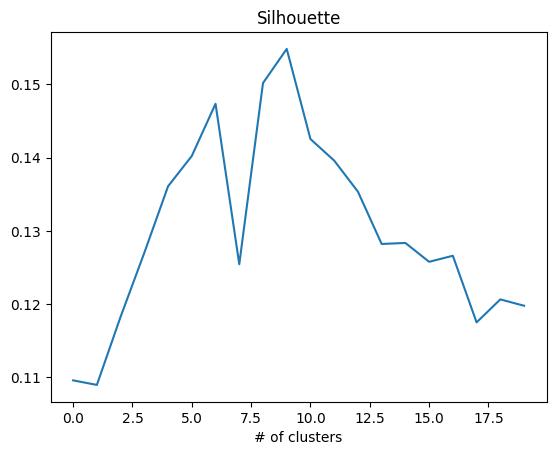

In [56]:
# Métrique silhouette

nb_classes =  range(0, 20)
metrique = np.array([])

for i in nb_classes:
    km = cluster.KMeans(n_clusters=i+2)
    km.fit(arr)
    metrique = np.append(metrique, metrics.silhouette_score(arr,km.labels_))


plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(nb_classes, metrique)
plt.show()

In [25]:
# Test
arr_test = sc.transform(test_data.drop(["class"], axis=1))
test_predictions = kmeans.predict(arr_test)

In [26]:
test_predictions

array([8, 8, 8, ..., 7, 7, 7])

In [27]:
test_predictions_df = pd.DataFrame({"class":test_data["class"], "class_kmeans_predicted":test_predictions})
test_predictions_df

,class,class_kmeans_predicted
0,0,8
1,0,8
2,0,8
3,0,8
4,0,8
...,...,...
215,9,7
216,9,7
217,9,7
218,9,7


In [28]:
pd.crosstab(test_data["class"], test_predictions)

col_0,0,1,2,3,4,5,6,7,8,9
class,,,,,,,,,,
0,0,0,0,0,1,1,0,0,20,0
1,2,0,0,0,1,0,19,0,0,0
2,0,0,0,1,20,0,0,1,0,0
3,1,21,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,1,0,0,4
5,0,0,22,0,0,0,0,0,0,0
6,0,0,1,0,0,1,0,0,0,20
7,0,0,0,16,4,0,0,2,0,0
8,0,0,0,0,0,22,0,0,0,0


In [30]:
#moyenne par variable
m = train_data.iloc[:,:-1].mean()

print("Moyennes par variables \n")
print(m)
print("\n===========================================\n")

#TSS
TSS = train_data.shape[0]*train_data.var(ddof=0)
print(TSS)

Moyennes par variables 

fac_1    272.40667
fac_2    323.12800
fac_3    773.47733
fac_4    756.78067
fac_5    640.51067
            ...   
zer_43   399.20443
zer_44     9.25331
zer_45    86.52476
zer_46    54.59280
zer_47   508.38428
Length: 649, dtype: float64


fac_1    12552181.93333
fac_2    17971533.42400
fac_3    29349998.22933
fac_4    18075582.83933
fac_5     3601832.82933
              ...      
zer_43   13708153.49438
zer_44      70266.41878
zer_45    4068600.94503
zer_46     181895.47253
zer_47    7533737.83960
Length: 649, dtype: float64


C:\Users\Nelly\AppData\Local\Temp\ipykernel_20644\4193523354.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TSS = df_train.shape[0]*df_train.var(ddof=0)


In [31]:
# Interprétation des classes avec le carré du rapport de corrélation

#dataframe conditionnellement aux groupes
gb_km = train_data.iloc[:,:-1].groupby(kmeans.labels_)

#effectifs conditionnels
nk_km= gb_km.size()

#moyennes conditionnelles
mk_km= gb_km.mean()

#print("Moyennes conditionnelles aux groupes \n")
#print(mk_km)
#print("\n===========================================\n")

#pour chaque groupe, écart à la moyenne par variable
EMk_km= (mk_km - m)**2

#pondéré par les effectifs du groupe
EM_km = EMk_km.multiply(nk_km,axis=0)

#somme des valeurs => BSS
BSS_km = np.sum(EM_km,axis=0)

#carré du rapport de corrélation = part de la variance expliquée par l'appartenance aux groupes
eta2_km = BSS_km/TSS

print("Part de la variance totale expliquée par l'appartenance aux groupes \n")
print(eta2_km.sort_values(ascending=False))

Part de la variance totale expliquée par l'appartenance aux groupes 

mor1      0.86137
fac_29    0.80143
fac_181   0.79393
fac_65    0.79355
fac_185   0.77792
            ...  
kar_57    0.05120
pix_37    0.04075
kar_59    0.04018
kar_61    0.03277
pix_36    0.02364
Length: 649, dtype: float64


In [32]:
print("Part de la variance totale expliquée par l'appartenance aux groupes : 15 premières variables \n")
print(eta2_km.sort_values(ascending=False).iloc[:15])

Part de la variance totale expliquée par l'appartenance aux groupes : 15 premières variables 

mor1      0.86137
fac_29    0.80143
fac_181   0.79393
fac_65    0.79355
fac_185   0.77792
mor2      0.77736
mor6      0.76314
fac_55    0.75919
fac_125   0.75722
fac_113   0.75460
fac_67    0.74765
kar_1     0.72963
fac_97    0.71910
fac_109   0.71845
mor5      0.71816
dtype: float64


In [33]:
# Moyennes conditionnelles aux groupes

d = {}
for i in range(10):
    d[f"classe_{i}"] = mk_km.T[i].sort_values(ascending=False).index[:15].tolist()


d

{'classe_0': ['mor6',
  'fac_185',
  'fac_198',
  'fac_65',
  'fac_29',
  'fac_78',
  'fac_113',
  'fac_173',
  'fac_135',
  'fac_102',
  'fac_183',
  'fac_18',
  'fac_162',
  'fac_42',
  'fac_53'],
 'classe_1': ['mor6',
  'fac_198',
  'fac_185',
  'fac_78',
  'fac_65',
  'fac_102',
  'fac_18',
  'fac_162',
  'fac_29',
  'fac_113',
  'fac_173',
  'fac_42',
  'fac_90',
  'fac_53',
  'fac_184'],
 'classe_2': ['mor6',
  'fac_198',
  'fac_78',
  'fac_18',
  'fac_102',
  'fac_162',
  'fac_195',
  'fac_148',
  'fac_185',
  'fac_196',
  'fac_90',
  'fac_42',
  'fac_136',
  'fac_40',
  'fac_4'],
 'classe_3': ['mor6',
  'fac_185',
  'fac_65',
  'fac_29',
  'fac_113',
  'fac_173',
  'fac_183',
  'fac_135',
  'fac_53',
  'fac_39',
  'fac_125',
  'fac_198',
  'fac_51',
  'fac_3',
  'fac_184'],
 'classe_4': ['mor6',
  'fac_185',
  'fac_65',
  'fac_29',
  'fac_113',
  'fac_173',
  'fac_184',
  'fac_198',
  'fac_53',
  'fac_135',
  'fac_125',
  'fac_183',
  'fac_147',
  'fac_64',
  'fac_112'],
 'clas

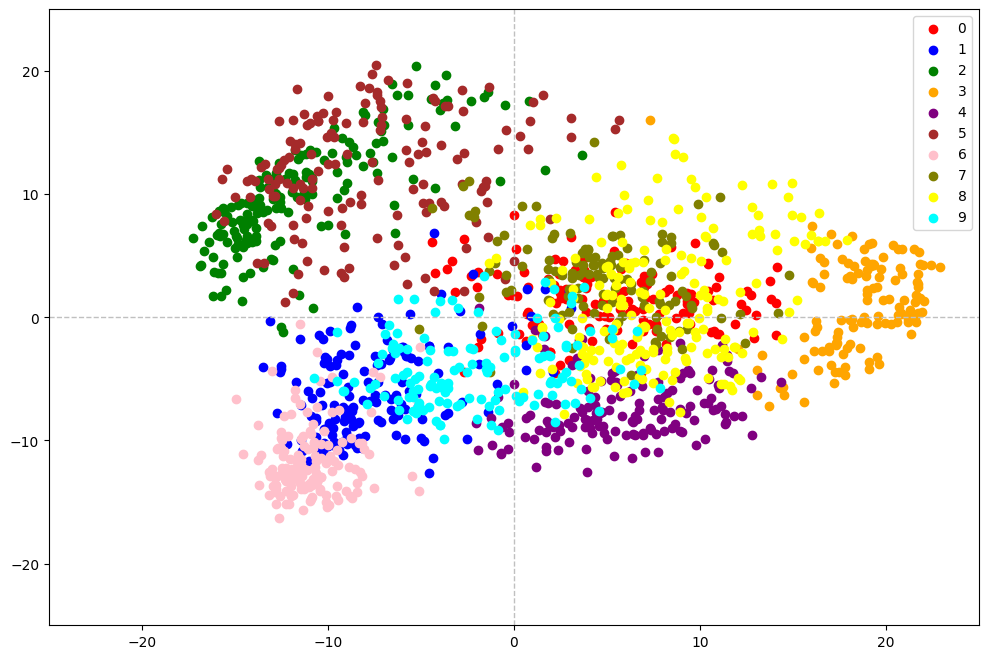

In [36]:
## Interprétation des classes (multivarié) pour tenir compte des liaisons entres les variables

coords = PCA(svd_solver="full", n_components=2).fit_transform(arr)

## Affichage des classes dans le 1er plan factoriel
plt.figure(figsize=(12,8))
couleurs = ["red","blue","green","orange","purple","brown","pink","olive","yellow","cyan"]
for couleur, k in zip(couleurs, np.unique(kmeans.labels_)):
    plt.scatter(coords[kmeans.labels_ == k , 0], coords[kmeans.labels_ == k, 1], c=couleur, label=k)

plt.legend()
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.axvline(0, color="silver", linestyle="dashed", linewidth=1)
plt.axhline(0, color="silver", linestyle="dashed", linewidth=1)
plt.show()

## <a id="clustering_kmeans_v2" style="color:black">ANALYSE MULTIVARIÉE : K-Means version 2 (groupes de variables)</a>

In [57]:
# Créer des patterns pour extraire les variables

ls_vars = list(df_train.columns)

fac_vars = [x for x in ls_vars if x.startswith("fac")]
four_vars = [x for x in ls_vars if x.startswith("fou")]
kar_vars = [x for x in ls_vars if x.startswith("kar")]
pix_vars = [x for x in ls_vars if x.startswith("pix")]
zer_vars = [x for x in ls_vars if x.startswith("zer")]
mor_vars = [x for x in ls_vars if x.startswith("mor")]

In [60]:
train_fac = train_data.loc[:, fac_vars + ["class"]].copy()
train_four = train_data.loc[:, four_vars + ["class"]].copy()
train_kar = train_data.loc[:, kar_vars + ["class"]].copy()
train_pix = train_data.loc[:, pix_vars + ["class"]].copy()
train_zer = train_data.loc[:, zer_vars + ["class"]].copy()
train_mor = train_data.loc[:, mor_vars + ["class"]].copy()

In [61]:
# Fonction clustering K-means

def clustering_kmeans(df, nclus=4, cible="class"):
    """
    Fonction qui prend en entrée le dataframe,le nombre de clusters voulus ainsi que le nom de la variable cible,
    et qui applique l'algorithme des k-means et l'analyse univariée des classes. 
    En sortie, on obtient l'objet kmeans.
    """
    n = df.shape[0]
    p = df.drop(cible, axis=1).shape[1]
    
    sc = StandardScaler()
    arr = sc.fit_transform(df.drop(cible, axis=1))
    
    kmeans = cluster.KMeans(n_clusters=nclus)
    kmeans.fit(arr)
    
    idk = np.argsort(kmeans.labels_)
    corresp_km = pd.DataFrame({"Class":df[cible][idk], "Cluster":kmeans.labels_[idk]})
    crosstab_km = pd.crosstab(corresp_km["Class"], corresp_km["Cluster"])

    #moyenne par variable
    m = df.drop(cible, axis=1).mean()

    #TSS
    TSS = df.shape[0]*df.var(ddof=0)
    
    #====== Interprétation des classes (univariée) #======
    gb_km = df.drop(cible, axis=1).groupby(kmeans.labels_)
    nk_km= gb_km.size()
    mk_km= gb_km.mean()
    EMk_km= (mk_km - m)**2
    EM_km = EMk_km.multiply(nk_km,axis=0)
    BSS_km = np.sum(EM_km,axis=0)

    #carré du rapport de corrélation
    eta2_km = BSS_km/TSS
    
    return kmeans.__dict__, corresp_km, crosstab_km, mk_km, eta2_km
    

In [63]:
ls_dataframes = [train_fac, train_four, train_kar, train_pix, train_zer, train_mor]

In [64]:
# kmeans les 6 groupes de variables
fac_km = {}
four_km = {}
kar_km = {}
pix_km = {}
zer_km = {}
mor_km = {}

ls_reskm = [fac_km, four_km, kar_km, pix_km, zer_km, mor_km]

for i,j in zip(ls_reskm, ls_dataframes):
    i["kmeansdict"], i["corresp_km"], i["crosstab_km"], i["mk_km"], i["eta2_km"] = clustering_kmeans(j, nclus=10)

C:\Users\Nelly\AppData\Local\Temp\ipykernel_18860\1418306397.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TSS = df.shape[0]*df.var(ddof=0)
C:\Users\Nelly\AppData\Local\Temp\ipykernel_18860\1418306397.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TSS = df.shape[0]*df.var(ddof=0)
C:\Users\Nelly\AppData\Local\Temp\ipykernel_18860\1418306397.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TSS = df.shape[0]*df.var(ddof=0)
C:\Users\Nelly\AppData\Local\Temp\ipykernel_18860

In [65]:
fac_km["crosstab_km"]

Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
0,0,2,0,0,0,0,124,0,2,0
1,3,2,100,2,8,1,0,1,11,0
2,2,0,0,0,124,1,0,1,0,0
3,7,0,1,0,8,4,0,0,1,107
4,1,0,0,18,0,0,0,55,54,0
5,31,59,0,0,16,0,0,0,7,15
6,0,5,0,84,0,0,0,33,5,1
7,12,0,0,0,22,94,0,0,0,0
8,0,108,0,0,5,0,8,0,6,1


In [66]:
fac_km["eta2_km"].sort_values(ascending=False)

fac_29    0.79601
fac_65    0.79122
fac_185   0.77927
fac_181   0.77866
fac_125   0.77052
            ...  
fac_95    0.17799
fac_215   0.17346
fac_168   0.16514
fac_114   0.10895
fac_60    0.09631
Length: 216, dtype: float64

In [67]:
four_km["crosstab_km"]

Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
0,12,0,0,0,0,116,0,0,0,0
1,3,4,78,1,24,0,0,7,11,0
2,0,2,96,0,4,0,0,0,26,0
3,0,0,12,9,25,0,18,56,0,8
4,0,9,4,53,15,0,28,5,2,12
5,0,0,0,1,25,0,75,27,0,0
6,1,10,1,16,44,0,0,14,0,42
7,0,35,8,1,0,0,1,1,73,9
8,125,0,0,2,0,0,1,0,0,0


In [68]:
four_km["eta2_km"].sort_values(ascending=False)

fou_5    0.68116
fou_73   0.61278
fou_69   0.60841
fou_7    0.60694
fou_72   0.59881
fou_71   0.55462
fou_74   0.54106
fou_76   0.53727
fou_2    0.52750
fou_8    0.52024
fou_3    0.49986
fou_1    0.47928
fou_63   0.45784
fou_14   0.42486
fou_11   0.40086
fou_10   0.39936
fou_70   0.39855
fou_13   0.39690
fou_61   0.39069
fou_6    0.39001
fou_15   0.38531
fou_67   0.37459
fou_65   0.36840
fou_18   0.34993
fou_66   0.32305
fou_23   0.31296
fou_12   0.30611
fou_58   0.30438
fou_16   0.29771
fou_17   0.28464
fou_60   0.27598
fou_55   0.27455
fou_20   0.27128
fou_26   0.26281
fou_9    0.25586
fou_53   0.25075
fou_59   0.24868
fou_24   0.24754
fou_75   0.23646
fou_44   0.23235
fou_56   0.23038
fou_51   0.22992
fou_21   0.22744
fou_45   0.22657
fou_30   0.22154
fou_33   0.22040
fou_34   0.22018
fou_47   0.21984
fou_22   0.21906
fou_52   0.21890
fou_64   0.21788
fou_57   0.21703
fou_38   0.21698
fou_68   0.21685
fou_49   0.21550
fou_40   0.20928
fou_28   0.20914
fou_31   0.19683
fou_4    0.195

In [69]:
kar_km["crosstab_km"]

Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
0,87,24,0,0,0,16,0,0,1,0
1,1,1,93,2,0,9,0,1,20,1
2,1,0,0,0,117,6,0,3,0,1
3,0,0,0,0,1,8,108,8,2,1
4,1,0,19,0,0,25,0,1,81,1
5,3,0,0,102,0,6,13,0,3,1
6,29,5,1,2,0,89,0,0,1,1
7,0,0,0,0,0,2,0,116,1,9
8,37,66,1,0,0,18,2,0,1,3


In [70]:
kar_km["eta2_km"].sort_values(ascending=False)

kar_3    0.62309
kar_1    0.61015
kar_21   0.48861
kar_11   0.47030
kar_4    0.46282
kar_6    0.45661
kar_28   0.44048
kar_43   0.42002
kar_26   0.41993
kar_12   0.40006
kar_5    0.38806
kar_25   0.38156
kar_10   0.37832
kar_31   0.37035
kar_2    0.34922
kar_9    0.34583
kar_15   0.34282
kar_44   0.34092
kar_36   0.33581
kar_40   0.32246
kar_19   0.31772
kar_27   0.31076
kar_23   0.29168
kar_34   0.29097
kar_20   0.28609
kar_18   0.28041
kar_14   0.27633
kar_16   0.27266
kar_38   0.26961
kar_37   0.26937
kar_39   0.26505
kar_47   0.25710
kar_8    0.25505
kar_56   0.24953
kar_42   0.24626
kar_45   0.23672
kar_24   0.22772
kar_52   0.22149
kar_49   0.21857
kar_7    0.21583
kar_22   0.20894
kar_48   0.20889
kar_51   0.20272
kar_29   0.19886
kar_64   0.19605
kar_50   0.19316
kar_60   0.18596
kar_13   0.18502
kar_62   0.17386
kar_33   0.17360
kar_53   0.16137
kar_17   0.15942
kar_63   0.15738
kar_54   0.15611
kar_32   0.14572
kar_55   0.14502
kar_30   0.13677
kar_58   0.13073
kar_46   0.123

In [71]:
pix_km["crosstab_km"]

Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
0,1,0,0,0,109,0,0,16,2,0
1,9,0,5,2,0,0,102,0,2,8
2,0,0,127,0,0,0,0,0,0,1
3,1,110,1,5,0,0,0,0,11,0
4,82,0,0,0,0,24,21,0,0,1
5,2,7,1,1,1,0,1,66,47,2
6,1,1,0,0,0,109,1,16,0,0
7,0,0,5,108,0,0,0,0,0,15
8,2,1,0,0,75,0,2,43,5,0


In [72]:
pix_km["eta2_km"].sort_values(ascending=False)

pix_178   0.77664
pix_193   0.74648
pix_192   0.73820
pix_163   0.73344
pix_177   0.72014
            ...  
pix_106   0.10210
pix_226   0.09129
pix_91    0.08365
pix_36    0.05455
pix_37    0.03424
Length: 240, dtype: float64

In [73]:
zer_km["crosstab_km"]

Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
0,0,0,1,1,119,7,0,0,0,0
1,2,0,16,1,0,1,54,1,50,3
2,0,1,2,60,3,57,0,4,0,1
3,16,5,5,69,0,17,1,10,0,5
4,14,9,37,0,0,0,41,10,17,0
5,24,1,12,21,7,49,6,6,1,1
6,32,0,3,2,2,5,1,81,0,2
7,5,92,3,1,0,1,0,4,0,22
8,1,0,3,5,88,20,0,11,0,0


In [74]:
zer_km["eta2_km"].sort_values(ascending=False)

zer_22   0.71730
zer_31   0.71058
zer_38   0.70023
zer_11   0.69519
zer_39   0.67765
zer_32   0.67713
zer_34   0.67350
zer_44   0.66756
zer_26   0.66113
zer_16   0.63313
zer_25   0.62940
zer_27   0.62319
zer_15   0.62237
zer_17   0.61041
zer_3    0.60751
zer_23   0.59803
zer_30   0.59437
zer_21   0.59037
zer_35   0.59033
zer_45   0.58483
zer_10   0.58280
zer_4    0.57104
zer_1    0.56708
zer_41   0.56549
zer_6    0.55372
zer_37   0.52178
zer_46   0.51127
zer_42   0.48087
zer_8    0.47514
zer_40   0.47468
zer_43   0.45571
zer_36   0.40322
zer_24   0.39434
zer_12   0.37712
zer_29   0.37630
zer_28   0.36787
zer_47   0.35385
zer_19   0.35382
zer_14   0.34510
zer_2    0.34036
zer_33   0.30364
zer_20   0.29613
zer_5    0.28287
zer_9    0.28039
zer_13   0.25678
zer_7    0.22182
zer_18   0.21632
dtype: float64

In [76]:
mor_km["crosstab_km"]

Cluster,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
0,0,0,0,0,2,0,126,0,0,0
1,0,2,5,0,0,0,0,74,1,46
2,1,3,10,0,108,5,0,1,0,0
3,0,40,15,0,9,41,0,1,22,0
4,0,78,28,0,1,0,0,2,15,4
5,0,9,5,0,44,70,0,0,0,0
6,127,0,0,0,0,0,0,1,0,0
7,0,14,108,0,3,0,0,1,0,2
8,3,0,0,121,4,0,0,0,0,0


In [77]:
mor_km["eta2_km"].sort_values(ascending=False)

mor1   0.99305
mor2   0.97970
mor3   0.97142
mor6   0.91798
mor5   0.88657
mor4   0.87858
dtype: float64

In [78]:
mor_km["kmeansdict"]["labels_"]

array([6, 6, 6, ..., 0, 0, 0])

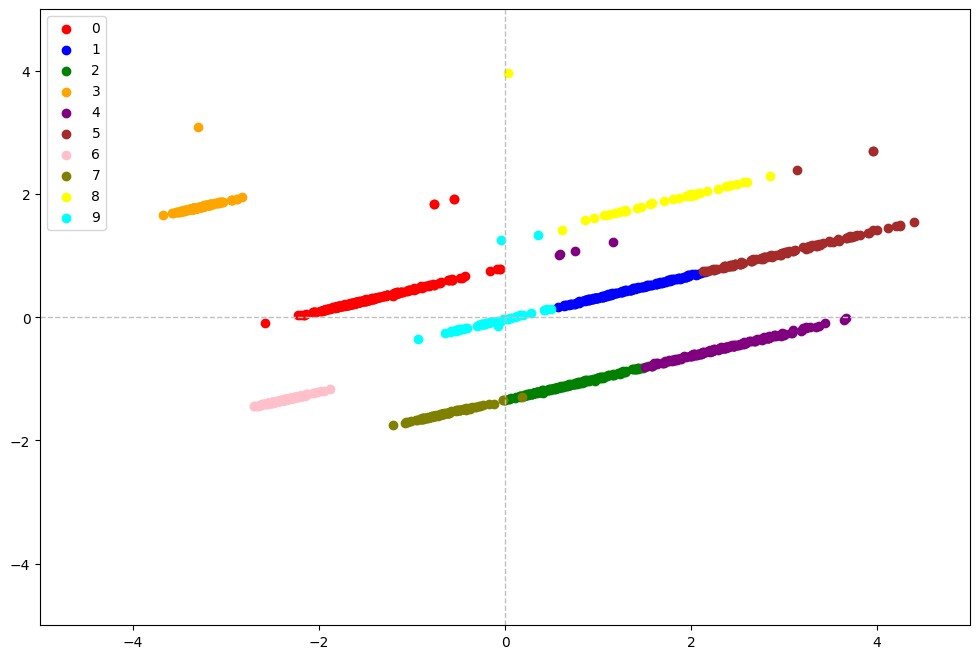

In [81]:
## Interprétation des classes (multivarié) pour tenir compte des liaisons entres les variables
## Ici, la véritable classe sera considérée comme une variable illustrative (quali)


sc_mor_km = StandardScaler()

arr_mor_km = sc_mor_km.fit_transform(train_mor.drop(["class"], axis=1))

acp_mor_km = PCA(svd_solver="full")
coords_mor_km = acp_mor_km.fit_transform(arr_mor_km)
val_propres_mor_km = (acp_mor_km.singular_values_**2/train_mor.shape[0])
ratio_expliq_mor_km = acp_mor_km.explained_variance_ratio_

## Affichage des classes dans le 1er plan factoriel
plt.figure(figsize=(12,8))
couleurs = ["red","blue","green","orange","purple","brown","pink","olive","yellow","cyan"]

for couleur, k in zip(couleurs, np.unique(mor_km["kmeansdict"]["labels_"])):
    plt.scatter(coords_mor_km[mor_km["kmeansdict"]["labels_"] == k , 0], \
                coords_mor_km[mor_km["kmeansdict"]["labels_"] == k, 1], c=couleur, label=k)

plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.axvline(0, color="silver", linestyle="dashed", linewidth=1)
plt.axhline(0, color="silver", linestyle="dashed", linewidth=1)
plt.show()

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.8</span>

Requirements.txt  

```
absl-py==2.1.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0       
arrow==1.2.3
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==4.2.4
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==2.0.12
colorama==0.4.6
comm==0.1.4
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
fonttools==4.42.1
fqdn==1.5.1
gast==0.3.3
google-auth==1.35.0
google-auth-oauthlib==0.4.6        
google-pasta==0.2.0
grpcio==1.66.2
h5py==2.10.0
htmlmin==0.1.12
idna==3.4
ImageHash==4.3.1
importlib-metadata==8.5.0
importlib-resources==6.4.5
ipykernel==6.25.2
ipython==8.12.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
Jinja2==3.1.2
joblib==1.1.1
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.0
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-client==8.3.1
jupyter-console==6.6.3
jupyter-core==5.3.1
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter-server==2.7.3
jupyter-server-terminals==0.4.4
jupyterlab==4.0.6
jupyterlab-pygments==0.2.2
jupyterlab-server==2.25.0
jupyterlab-widgets==3.0.9
Keras==2.4.3
Keras-Preprocessing==1.1.2
kiwisolver==1.4.5
Markdown==3.7
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
missingno==0.5.2
mistune==3.0.1
multimethod==1.8
nbclient==0.8.0
nbconvert==7.8.0
nbformat==5.9.2
nest-asyncio==1.5.8
networkx==3.1
notebook==7.0.3
notebook-shim==0.2.3
numpy==1.22.0
oauthlib==3.2.2
opt-einsum==3.4.0
overrides==7.4.0
packaging==23.1
pandas==1.4.0
pandas-profiling==3.3.0
pandocfilters==1.5.0
parso==0.8.3
patsy==0.5.3
pexpect==4.8.0
phik==0.12.3
pickleshare==0.7.5
Pillow==10.0.1
pkgutil-resolve-name==1.3.10
platformdirs==3.10.0
prometheus-client==0.17.1
prompt-toolkit==3.0.39
protobuf==3.20.3
psutil==5.9.5
ptyprocess==0.7.0
pure-eval==0.2.2
pyasn1==0.6.1
pyasn1-modules==0.4.1
pycparser==2.21
pydantic==1.9.2
Pygments==2.16.1
pyparsing==3.1.1
python-dateutil==2.8.2
python-json-logger==2.0.7
pytz==2023.3.post1
PyWavelets==1.4.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==25.1.1
qtconsole==5.4.4
QtPy==2.4.0
referencing==0.30.2
requests==2.28.0
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.10.3
rsa==4.9
scikit-learn==0.23.2
scipy==1.4.1
seaborn==0.11.2
Send2Trash==1.8.2
six==1.16.0
sniffio==1.3.0
soupsieve==2.5
stack-data==0.6.2
statsmodels==0.13.5
tangled-up-in-unicode==0.2.0
tensorboard==2.2.2
tensorboard-plugin-wit==1.8.1
tensorflow==2.2.0
tensorflow-estimator==2.2.0
termcolor==2.4.0
terminado==0.17.1
threadpoolctl==3.5.0
tinycss2==1.2.1
tomli==2.0.1
tornado==6.3.3
tqdm==4.64.1
traitlets==5.10.0
typing-extensions==4.7.1
uri-template==1.3.0
urllib3==1.26.16
visions==0.7.5
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.6.3
werkzeug==3.0.4
widgetsnbextension==4.0.9
wrapt==1.16.0
xlrd==2.0.1
zipp==3.20.2
```